## 2. Acquire the Data

We have downloaded the data from https://www.backblaze.com/hard-drive-test-data.html

**Data Formats**
- csv files

As the files are related, instead of reading everything file by file, its better to offload this data into a 
simple database so that we can query on the data easily.

**Database**
- SQLite



# Creating entries in SQLite using pandas and sqlalchemy

In [ ]:
import pandas as pd
from sqlalchemy import create_engine
import os

In [ ]:
path = os.path.join(os.getcwd(),'data')

In [ ]:
engine = create_engine('sqlite:////home/nischal/hard-disk-reduced.db')
#engine = create_engine('sqlite:////Users/standy/hard-disk.db')



In [ ]:
total_rows = 0
inp_df = pd.DataFrame()
no_of_files = 0
total_files = len(os.listdir(path))
file_counter = 0
for file in os.listdir(path):
    
    no_of_files = no_of_files + 1
    file_counter = file_counter + 1
    print no_of_files,file_counter
    inp_temp_df = pd.read_csv(os.path.join(path,file))
    
    if inp_df.shape[0] == 0:
        inp_df = inp_temp_df
    else:
        inp_df = inp_df.append(inp_temp_df)
    
    if no_of_files == 3 or file_counter == total_files:
        no_of_files = 0
        inp_df.to_sql("data",engine,index=False,chunksize=None,if_exists='append')
        inp_df = pd.DataFrame()

    total_rows = total_rows + inp_temp_df.shape[0]

print 'loading data done with rows '+str(total_rows)

# Now the data is sitting inside SQLite, let us start refining the data

Now let us read what are the column names

In [ ]:
total_df = pd.read_sql_query(sql='''SELECT  from data limit 2000000''' ,con=engine)

In [ ]:
total_df.fillna(0,inplace=True)

In [ ]:
from scipy.stats import pearsonr
import numpy as np

In [ ]:
required_smart_columns = {}
for column in total_df.ix[:,5:]:
    correlation, p_value = pearsonr(total_df.failure,total_df[column])

    if not np.isnan(correlation):
        print column,correlation,p_value
        required_smart_columns[column] = correlation
    
    
   


In [ ]:
required_smart_columns

In [ ]:
required_df = total_df.ix[:,:4]

In [ ]:
required_df.columns

In [ ]:
for k,v in required_smart_columns.iteritems():
    required_df = required_df.append(total_df[k])

In [ ]:
reduced_data_df = pd.read_sql_query(sql='''select model,date,serial_number,capacity_bytes,failure,smart_1_raw,smart_5_raw,smart_9_raw,smart_194_raw,smart_197_raw from data where date between '2013-04-10' and '2013-08-20' ''',con=engine)

In [ ]:
reduced_data_df.head()

In [ ]:
reduced_data_df.columns

In [ ]:
reduced_data_df.to_csv('hard_disk_data.csv')

In [ ]:
reduced_data_df.to_sql("data",engine,index=False,chunksize=None,if_exists='append')

# Exploring the data

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine
import os
import seaborn as sns

In [2]:
engine = create_engine('sqlite:////home/nischal/hard-disk-reduced.db')

In [3]:
%matplotlib inline

# Quantitative variable - Single Variable

> Let us get a particular model and see when it fails

In [4]:
distinct_models = pd.read_sql_query(sql="select distinct(model) from data",con=engine)

In [5]:
distinct_models.model[0]


u'Hitachi HDS5C3030ALA630'

In [43]:
failure_data_for_model_df = pd.read_sql_query(sql='''SELECT date,count(failure) as fail_count 
                                                    from data where model = '%s' and failure = 1
                                                    group by date order by date  '''
                                              %(distinct_models.model[0]),con=engine)

In [11]:
failure_data_for_model_df.head()

,date,fail_count
0,2013-04-16,1
1,2013-04-17,2
2,2013-05-03,6
3,2013-05-13,2
4,2013-07-08,1


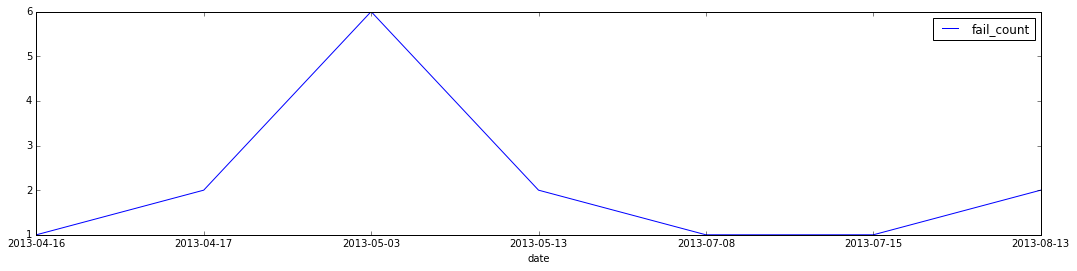

In [12]:
failure_data_for_model_df.plot(x = "date",y = "fail_count",figsize=(18,4))

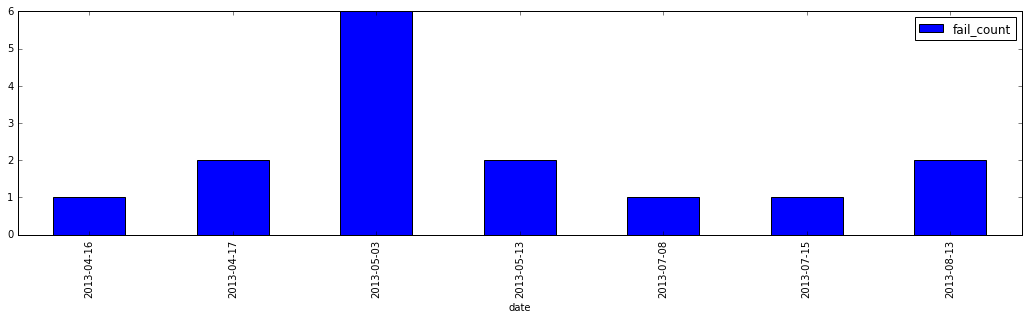

In [22]:
# we see that visualizing the failures using line graph not give us much clarity, using a bar chart will help us
# understand the failures better
failure_data_for_model_df.plot(kind="bar",x = "date",y = "fail_count",figsize=(18,4))

In [23]:
# model vs failures


In [31]:
failure_data_for_models_df = pd.read_sql_query(sql='''SELECT model,count(failure) as fail_count 
                                                    from data where failure = 1
                                                    group by model''',con=engine)

In [32]:
failure_data_for_models_df.head()

,model,fail_count
0,HGST HMS5C4040ALE640,1
1,Hitachi HDS5C3030ALA630,15
2,Hitachi HDS5C4040ALE630,16
3,Hitachi HDS722020ALA330,16
4,Hitachi HDS723020BLA642,1


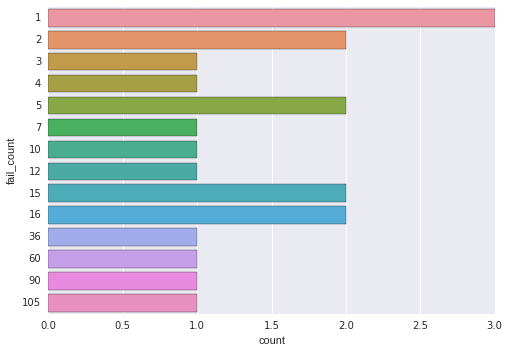

In [39]:
sns.countplot(y='fail_count',data=failure_data_for_models_df)

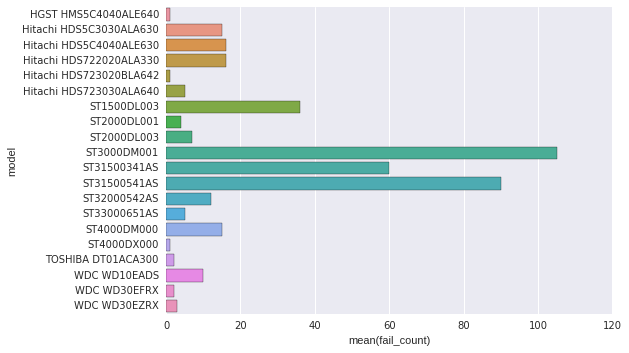

In [42]:
sns.barplot(y='model',x='fail_count',data=failure_data_for_models_df)

In [50]:
# capacity vs failure for 1 model
failure_data_for_model_capacity_df = pd.read_sql_query(sql='''SELECT capacity_bytes,count(failure) as fail_count 
                                                    from data where model = '%s' and failure = 1
                                                    group by date order by date  '''
                                              %(distinct_models.model[0]),con=engine)


In [51]:
failure_data_for_model_capacity_df.head()

,capacity_bytes,fail_count
0,3000592982016,1
1,3000592982016,2
2,3000592982016,6
3,3000592982016,2
4,3000592982016,1


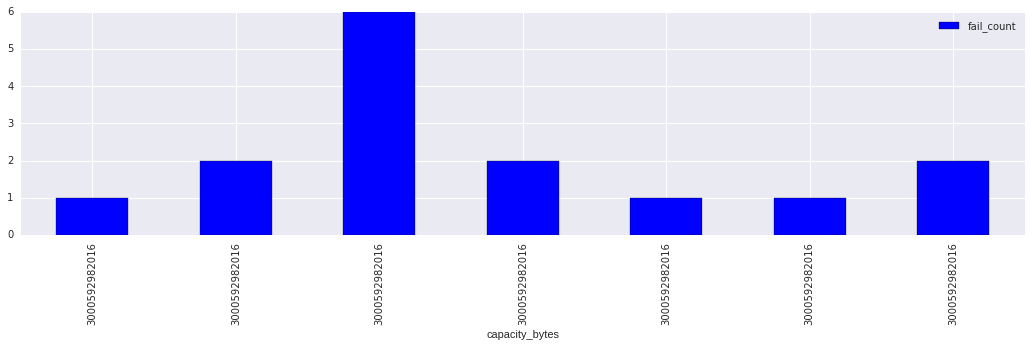

In [56]:
failure_data_for_model_capacity_df.plot(kind="bar",x="capacity_bytes",y="fail_count",figsize=(18,4))

In [60]:
#across all models , capacity vs failure
failure_data_for_all_model_capacity_df = pd.read_sql_query(sql='''SELECT capacity_bytes,count(failure) as fail_count,model  
                                                    from data where failure = 1
                                                    group by model '''
                                             ,con=engine)

In [61]:
failure_data_for_all_model_capacity_df.head()

,capacity_bytes,fail_count,model
0,4000787030016,1,HGST HMS5C4040ALE640
1,3000592982016,15,Hitachi HDS5C3030ALA630
2,4000787030016,16,Hitachi HDS5C4040ALE630
3,2000398934016,16,Hitachi HDS722020ALA330
4,2000398934016,1,Hitachi HDS723020BLA642


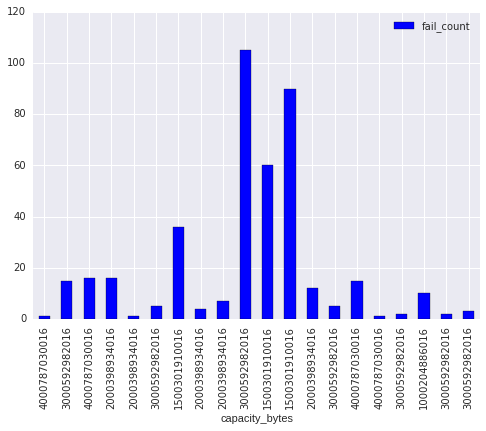

In [65]:
failure_data_for_all_model_capacity_df.plot(x="capacity_bytes",y="fail_count",kind="bar")

In [67]:
# over time capacity vs failure
failure_data_capacity_time_df = pd.read_sql_query(sql='''SELECT date,capacity_bytes,failure 
                                                    from data order by date'''
                                             ,con=engine)

In [68]:
failure_data_capacity_time_df.head()

,date,capacity_bytes,failure
0,2013-04-10,3000592982016,0
1,2013-04-10,3000592982016,0
2,2013-04-10,3000592982016,0
3,2013-04-10,3000592982016,0
4,2013-04-10,3000592982016,0


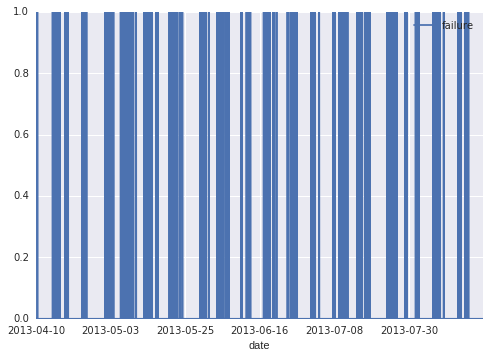

In [70]:
failure_data_capacity_time_df.plot(x="date",y="failure")

capacity_bytes
1000204886016    Axes(0.125,0.125;0.775x0.775)
1500301910016    Axes(0.125,0.125;0.775x0.775)
2000398934016    Axes(0.125,0.125;0.775x0.775)
3000592982016    Axes(0.125,0.125;0.775x0.775)
4000787030016    Axes(0.125,0.125;0.775x0.775)
dtype: object

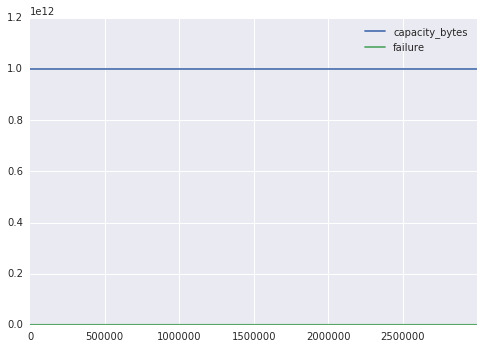

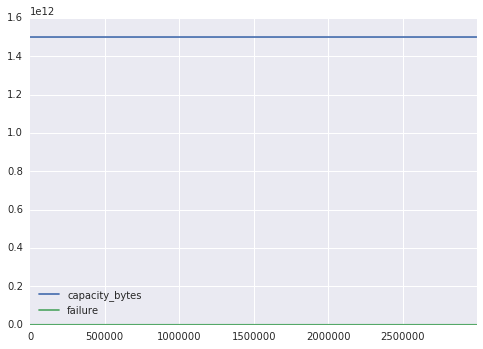

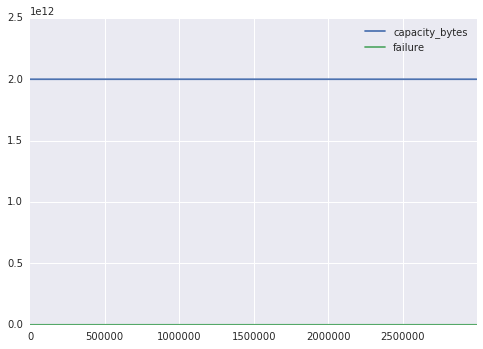

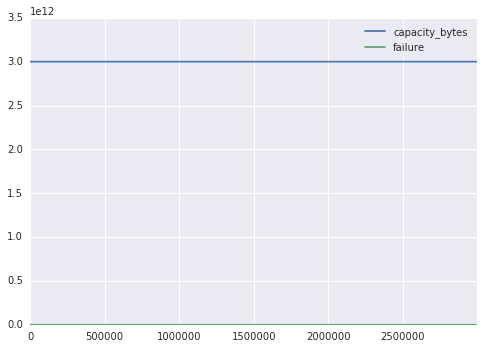

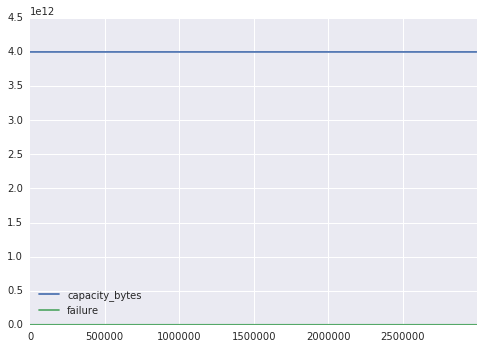

In [69]:
failure_data_capacity_time_df.groupby("capacity_bytes").plot(x="date",y="failure")